## Optimization of the mean-variance problem for portfolio theory

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import pandas.io.data as web
np.random.seed(123)
import datetime
# Turn off progress printing 
solvers.options['show_progress'] = False

## From Quadratic Optimization

In [124]:
def optimal_portfolio_quad(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return list(wt), returns, risks

## From Monte Carlo Simulation

In [104]:
## Monte Carlo Simulation
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T) * np.sqrt(252)/len(returns)
    return (w,mu,sigma)

def optimal_portfolio_stat(returns):
    n_portfolios = 15000
    optimal_weights = []
    best_sharpe = 0
    optimal_mean = 0
    optimal_std = 0
    for i in range(n_portfolios):
        w_vector, mean, std = random_portfolio(return_vec)
        sharpe = mean/std
        if sharpe > best_sharpe:
            optimal_weights = w_vector
            optimal_mean = mean
            optimal_std = std
            best_sharpe = sharpe
    return optimal_weights.tolist()[0], best_sharpe.tolist()[0],optimal_mean.tolist()[0],optimal_std.tolist()[0]

def plot_efficiency_frontier(returns):
    n_portfolios = 1500
    means, stds = np.column_stack([random_portfolio(returns)[1:3] for _ in range(n_portfolios)])
    return means,stds

## Testing

In [99]:
portfolio = ['YHOO','STK','GOOGL','AMZN','EBAY']
def pull_returns(symbol):
    request = web.DataReader(symbol,'yahoo',datetime.datetime(2010, 1, 1))['Close']
    returns = request.pct_change()[1:len(request)-1]
    returns *= 100
    return returns
returns_grid = []
for asset in portfolio:
    returns_grid.append(pull_returns(asset))
return_vec = np.array(pd.DataFrame(returns_grid).transpose()).transpose()

In [100]:
np.shape(return_vec)

(5, 1706)

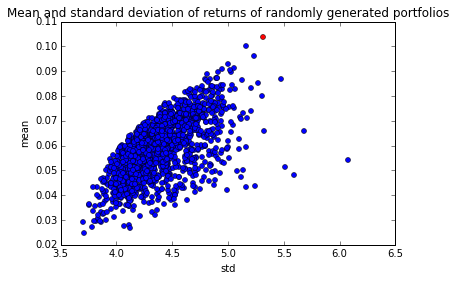

In [105]:
optimal_weights, best_sharpe, best_mean,best_std = optimal_portfolio_stat(return_vec)
means,stds = plot_efficiency_frontier(return_vec)
plt.plot(stds, means, 'o', markersize=5)
plt.plot(best_std, best_mean, 'o', markersize=5,color='red')
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [106]:
optimal_weights

[0.19164053554646812,
 0.007518166157004641,
 0.043643108872784046,
 0.6483615449120359,
 0.10883664451170734]

In [107]:
best_sharpe

[0.019567356967210906]

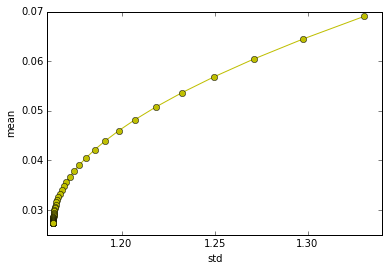

In [120]:
weights, returns, risks = optimal_portfolio_quad(return_vec)
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [123]:
list(weights)

[0.19968032011244616,
 0.3419445467851153,
 0.06529169212805187,
 0.33721668905492425,
 0.0558667519194624]